- By: Proskurin Oleksandr
- Email: proskurinolexandr@gmail.com
- Reference: Advances in Financial Machine Learning, Marcos Lopez De Prado, pg 37-38

# The Single Futures Roll

Building trading strategies on futures contracts has the unique problem that a given contract is for a short duration of time, example the 3 month contract on wheat. In order to build a continuous time series across the different contracts we stitch them together, most commonly using an auto roll or some other function. However a problem occurs when we do this, which is: come the expiry date, there is usually a price difference between the old contract and the new one. Often this difference is quite small, however for some contracts it can be quite substantial (especially if the underlying asset has a high carry costs).
 
Consider the following example:
September futures contract on wheat expires on December 2019, the next contract is March 2020. At the December expiration, the date at which we want to roll the contracts, the prices are:
- December close: 100
- March open: 120

One option, which we see many people defaulting to, is to simply ignore the price difference and state the new price to be 120. A disadvantage to using this approach is if we were to train a model on this data, it will learn that every three months, around the date of expiry, prices will spike in an upward/downward fashion. It may make the wrong assumption that this is a tradeable opportunity, when in reality it isn’t. This would lead to false buy/sell signals.

So what method could we apply to remedy this? The answer is the Futures Roll Trick.

The book reads: 
"The ETF trick can handle the rolls of a single futures contract, as a particular case of a 1-legged spread. However, when dealing with a single futures contract, an equivalent and more direct approach is to form a time series of cumulative roll gaps, and detract that gaps series from the price series." (pg 36, AFML)

### Note: 
On further expirations the adjustment factor need to be accounted for as follows 

* Absolute returns: adjustment_factor = previous_adjustment_factor + new_roll_gap.
* Relative returns:  adjustment_factor = previous_adjustment_factor * new_roll_gap.

Let's look how Futures Roll Trick works on an example of S&P500 Emini futures contracts.

In [1]:
import numpy as np
import pandas as pd
import mlfinlab as ml

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

**Caveat:**
For this notebook we made use of our inhouse data which we are not able to share due to legal constraints. We recommend you apply the same logic to your own data.

In [2]:
aggregated_df = pd.read_csv('../Sample-Data/volume_bars_es_with_nearest_contract.csv', index_col = 0, parse_dates = [0])

In [3]:
aggregated_df.head()

,open,high,low,close,volume,ticker,nearest_contract
date_time,,,,,,,
2011-01-02 21:50:39,1256.00,1261.0,1255.25,1260.00,20015,ESH11,ESH11
2011-01-03 02:00:37,1260.00,1261.5,1258.50,1258.75,20006,ESH11,ESH11
2011-01-03 02:47:12,1258.75,1261.5,1258.50,1260.00,20040,ESH11,ESH11
2011-01-03 04:11:34,1260.00,1261.0,1259.00,1260.50,20146,ESH11,ESH11
2011-01-03 06:01:23,1260.50,1261.5,1260.50,1260.50,20005,ESH11,ESH11


In [4]:
aggregated_df.tail(2)

,open,high,low,close,volume,ticker,nearest_contract
date_time,,,,,,,
2017-12-29 15:14:27.864,2672.50,2673.5,2671.75,2673.25,20011,ESH18,ESH18
2017-12-29 15:57:21.199,2673.25,2673.5,2668.00,2668.25,20167,ESH18,ESH18


## Create Continuous Contracts

In [5]:
# Get roll gaps (absolute and relative)
roll_gaps_absolute = ml.multi_product.get_futures_roll_series(aggregated_df, open_col='open', close_col='close',
                                                   sec_col='ticker', current_sec_col='nearest_contract', method='absolute')

roll_gaps_relative = ml.multi_product.get_futures_roll_series(aggregated_df, open_col='open', close_col='close',
                                                   sec_col='ticker', current_sec_col='nearest_contract', method='relative')

In [6]:
# Filter out rows where there is a roll (a change in nearest contract)
# This forms the basis of the continuous contract
continuous_contract = aggregated_df[aggregated_df.ticker == aggregated_df.nearest_contract]
continuous_contract.head()

,open,high,low,close,volume,ticker,nearest_contract
date_time,,,,,,,
2011-01-02 21:50:39,1256.00,1261.0,1255.25,1260.00,20015,ESH11,ESH11
2011-01-03 02:00:37,1260.00,1261.5,1258.50,1258.75,20006,ESH11,ESH11
2011-01-03 02:47:12,1258.75,1261.5,1258.50,1260.00,20040,ESH11,ESH11
2011-01-03 04:11:34,1260.00,1261.0,1259.00,1260.50,20146,ESH11,ESH11
2011-01-03 06:01:23,1260.50,1261.5,1260.50,1260.50,20005,ESH11,ESH11


Subtract or divide the gaps from close prices. This depends on if you are using the absolute or relative method.

In [7]:
# Make a copy of the first contract
continuous_contract_absolute_method = continuous_contract.copy()
continuous_contract_relative_method = continuous_contract.copy()

# Apply the roll gaps
continuous_contract_absolute_method['close'] -= roll_gaps_absolute
continuous_contract_relative_method['close'] /= roll_gaps_relative

Plot nearest continuous futures contract the using different fill methods.

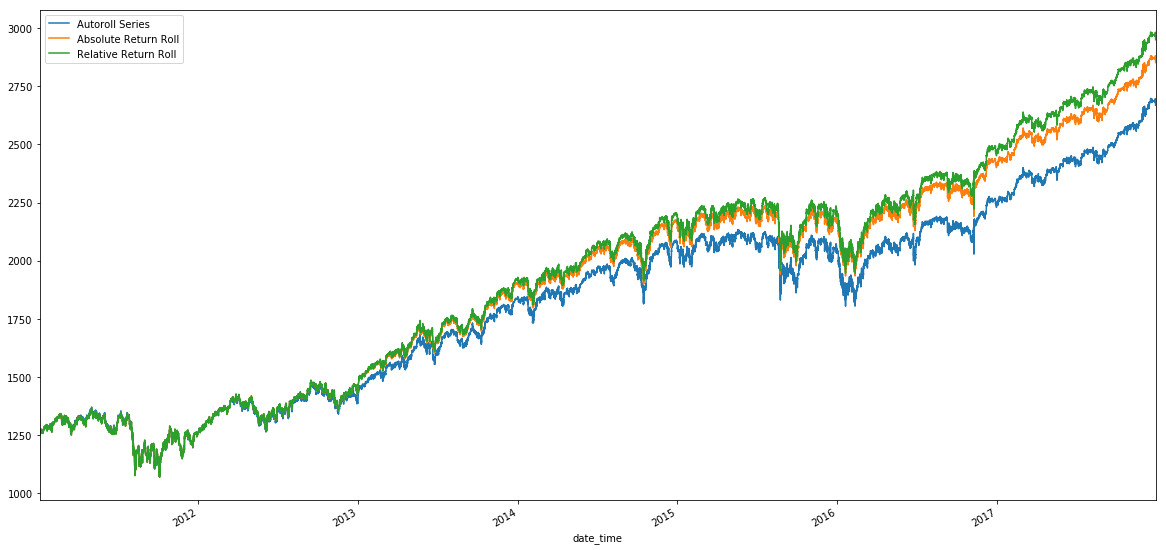

In [8]:
# Plot
plt.figure(figsize=(20, 10))
continuous_contract.close.plot(label = 'Autoroll Series')
continuous_contract_absolute_method.close.plot(label = 'Absolute Return Roll')
continuous_contract_relative_method.close.plot(label = 'Relative Return Roll')
plt.legend(loc='best')
plt.show()

## Conclusion

As you can see, accounting for the differences in contract prices can be quite substantial, by not accounting for it you add additional noise to the model.


### Notes from the book:
"Rolled prices are used for simulating PnL and portfolio mark-to-market values. However, raw prices should still be used to size positions and determine capital consumption. Keep in mind, rolled prices can indeed become negative, particularly in futures contracts that sold off while in contango." (pg 37, AFML)